<a href="https://colab.research.google.com/github/rohitkumyadav/EPBL-Project-AKTU/blob/main/Model_Trainin%2Btesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub   # Python module to download data direcly from 'Kaggle'

# Download the dataset

In [2]:

# Import the KaggleHub library to access and download datasets
import kagglehub

# Download the "Eye Diseases Classification" dataset from KaggleHub
dataset = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

# Print the path where the dataset is downloaded
print("Path to dataset files:", dataset)

100%|██████████| 736M/736M [00:13<00:00, 59.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


In [3]:
%cd /content/

/content


# Moving to the current Directory

In [4]:
## Moving to the pwd

import shutil   # high-level operation on a file like a copy, create, and remote operation on the file

source_path = "/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1"  # Destination
destination_path = "/content/"                                                                          # Currrent dir

shutil.move(source_path, destination_path)
print(f"Dataset moved to: {destination_path}")


Dataset moved to: /content/


# Checking if the file is present in the particular Directory or not


In [6]:
# Import the shutil module for high-level file operations (copy, move, delete)
import shutil

# Define the source path where the dataset is initially stored after downloading from KaggleHub
source_path = "/root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1"

# Define the destination path (current working directory in Google Colab)
destination_path = "/content/"

# Move the dataset from the source path to the destination path
shutil.move(source_path, destination_path)

# Print confirmation message
print(f" Dataset successfully moved to: {destination_path}")

Error: Destination path '/content/1' already exists

# Creating Directories for Train, Validation, and Test
### `Train: 87%, Valid: 8%, Test: 4%)`

In [7]:
import os
import shutil
import random

# Define dataset path
original_dataset_path = "/content/1/dataset"  # Original Path of the dataset

# Define new paths
train_path = "/content/data/train"     # Training folder
val_path = "/content/data/validation"  # Validation folder
test_path = "/content/data/test"       # test folder

# checks if the dir exists of not
categories = os.listdir(original_dataset_path)  # Get categories (disease classes)

for category in categories:
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(val_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)

# Split ratios
train_ratio = 0.87  # 87%
val_ratio = 0.08    # 8%
test_ratio = 0.05   # 5%

# Track statistics
stats = {"train": 0, "validation": 0, "test": 0}

# Splitting images
for category in categories:
    category_path = os.path.join(original_dataset_path, category)

    # Ensure it's a directory
    if not os.path.isdir(category_path):
        continue

    # List only valid image files
    valid_extensions = (".jpg", ".jpeg", ".png")
    images = [img for img in os.listdir(category_path) if img.lower().endswith(valid_extensions)]

    # Shuffle images to randomize the split
    random.shuffle(images)

    # Compute split indexes
    train_idx = int(len(images) * train_ratio)
    val_idx = train_idx + int(len(images) * val_ratio)
    train_images = images[:train_idx]
    val_images = images[train_idx:val_idx]
    test_images = images[val_idx:]

    # Copy images to respective folders (to avoid removing original files)
    for img in train_images:
        src = os.path.join(category_path, img)
        dest = os.path.join(train_path, category, img)
        if os.path.exists(src):
            shutil.copy(src, dest)
            stats["train"] += 1

    for img in val_images:
        src = os.path.join(category_path, img)
        dest = os.path.join(val_path, category, img)
        if os.path.exists(src):
            shutil.copy(src, dest)
            stats["validation"] += 1

    for img in test_images:
        src = os.path.join(category_path, img)
        dest = os.path.join(test_path, category, img)
        if os.path.exists(src):
            shutil.copy(src, dest)
            stats["test"] += 1

# Display final dataset distribution
print(f"Dataset successfully split into Train ({stats['train']} images), Validation ({stats['validation']} images), and Test ({stats['test']} images).")


Dataset successfully split into Train (3668 images), Validation (335 images), and Test (214 images).


# Data Preprocessing

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Data Augmentation for Training Set
# To help the model learn better, we'll tweak the training images in random ways

train_datagen = ImageDataGenerator(
    rescale=1./255,  #  Normalize pixel values to be between 0 and 1
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    brightness_range=[0.5, 1.5],  # Adjust brightness to make the model robust to lighting changes
    zoom_range=0.4,  # Randomly zoom in/out on images by up to 40%
    horizontal_flip=True,  # Flip images horizontally (simulate different perspectives)
    vertical_flip=True,  #  Flip images vertically (useful for medical images)
    fill_mode="nearest"  # Fills missing pixels after transformations
)

# - Only **rescaling** is applied to keep pixel values between 0 and 1.
val_test_datagen = ImageDataGenerator(rescale=1./255)  # for better accuracy

# Loading the data and # - The dataset must be **organized in separate folders for each class**.
train_generator = train_datagen.flow_from_directory(
    "/content/data/train",  #  Path to training data
    target_size=(299, 299),  #  Resize images to 299x299 (Xception’s expected input size)
    batch_size=16,  #  Train the model with 16 images per batch (adjustable based on RAM/GPU)
    class_mode="categorical"  #  Multi-class classification (4 categories)
)

val_generator = val_test_datagen.flow_from_directory(
    "/content/data/validation",  #  Path to validation data
    target_size=(299, 299),
    batch_size=16,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    "/content/data/test",  #  Path to test data
    target_size=(299, 299),
    batch_size=16,
    class_mode="categorical"
)

Found 3668 images belonging to 4 classes.
Found 335 images belonging to 4 classes.
Found 214 images belonging to 4 classes.


#  Compute Class Weights for Data Imbalance

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class labels
y_true = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_true), y=y_true)
class_weights_dict = {i: class_weights[i] for i in range(len(class_labels))}

print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 1.0155038759689923, 1: 0.9602094240837696, 2: 1.0468036529680365, 3: 0.9817987152034261}


# Using Model :`Xception`
## choosing ```Fine-Tuning``` Xception Model for better Accuracy

In [ ]:
# Import necessary TensorFlow/Keras modules
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [26]:
# Load the Pre-trained Xception Model without the top layers

## - Input shape is set to (299, 299, 3) since Xception expects this image size
base_model = Xception(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# - We freeze the **first 100 layers** so they don’t get modified during training
# - These layers contain generic image features useful for any classification task
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add Custom Classification Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # # Converts feature maps into a vector # You can also use flatten()
x = Dense(256, activation="relu")(x)  # Reduce neurons to prevent overfitting
x = Dropout(0.5)(x)  # Reduces overfitting by randomly dropping 50% of neurons ||  increased from 0.4 to 0.5
output_layer = Dense(4, activation="softmax")(x)  # 4 output classes

# - Combines the pre-trained Xception model with our custom classification layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
optimizer = Adam(learning_rate=0.0001)  # # - `Adam` optimizer with a small learning rate (0.0001) for stable fine-tuning
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# - This will show the architecture, number of trainable parameters, and layer details
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 10,003,916 (38.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

# Adjusting Fine-Tuning Xception for Better Performance

In [ ]:
# Unfreeze More Layers for Fine-Tuning
for layer in base_model.layers[50:]:   #  Unfreeze layers from 50 onwards
    layer.trainable = True

# Compile Again with a Lower Learning Rate
optimizer_finetune = Adam(learning_rate=0.00001)  # Very small learning rate for fine-tuning
model.compile(optimizer=optimizer_finetune, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping to Prevent Overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",  #  Track validation loss (best metric for generalization)
    patience=3,  # if validation loss doesn’t improve for 3 epochs, stop training
    restore_best_weights=True  # Load the best model weights before overfitting started
)

# Training the Fine-Tuned Model

In [28]:

# Mode; Training
history = model.fit(
    train_generator,
    epochs=20,  # Train for a maximum of 20 epochs
    validation_data=val_generator,
    class_weight=class_weights_dict,  # Adjust training for imbalanced classes
    callbacks=[early_stopping]  #  Stop training early if needed
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 192s 680ms/step - accuracy: 0.3696 - loss: 1.3052 - val_accuracy: 0.6567 - val_loss: 0.9957
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 126s 547ms/step - accuracy: 0.6286 - loss: 0.9379 - val_accuracy: 0.7343 - val_loss: 0.7254
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 128s 556ms/step - accuracy: 0.7095 - loss: 0.7510 - val_accuracy: 0.7463 - val_loss: 0.6343
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 124s 540ms/step - accuracy: 0.7599 - loss: 0.6384 - val_accuracy: 0.7701 - val_loss: 0.5813
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 125s 544ms/step - accuracy: 0.7854 - loss: 0.5884 - val_accuracy: 0.8060 - val_loss: 0.5434
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 124s 539ms/step - accuracy: 0.8096 - loss: 0.5422 - val_accuracy: 0.8090 - val_loss: 0.5245
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 123s 535ms/step - accuracy: 0.8169 - loss: 0.4981 - val_accuracy: 0.8179 - val_loss: 0.4766
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 125s 543ms/step - accuracy: 0.8183 -

# Tesing for Accuracy ans loss

In [31]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Print Test Accuracy
print(f"Fine-Tuned Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - accuracy: 0.8918 - loss: 0.3452
Fine-Tuned Test Accuracy: 86.45%
Test Loss: 0.3763


# Model Saving

In [29]:
# Save the trained model
model.save("xception.h5")
print("Model saved successfully!")


Model saved successfully!


# Plot Training & Validation Accuracy


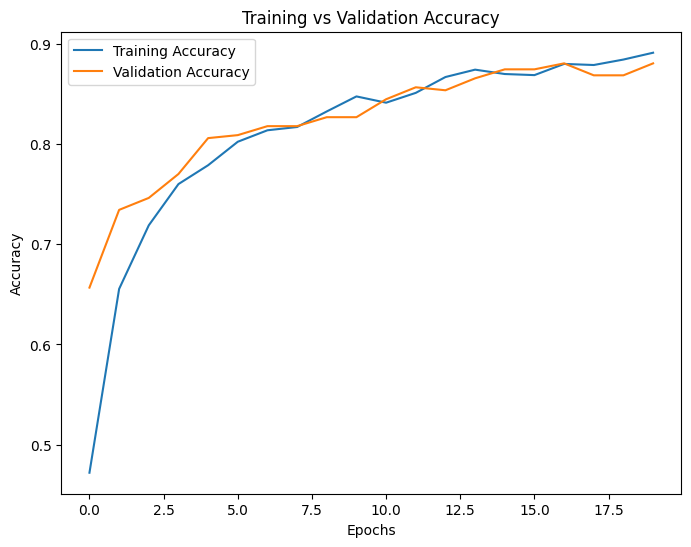

In [32]:
import matplotlib.pyplot as plt # For data visualization

# Grab the accuracy values from the training history
acc = history.history['accuracy']  # Training accuracy over each epoch
val_acc = history.history['val_accuracy']  # Validation accuracy over each epoch
epochs_range = range(len(acc))  # Create a range for the x-axis (epochs)

# Plot the Accuracy Graph
# Let's visualize how well the model learned over time
plt.figure(figsize=(8, 6))  # Set the size of the graph
plt.plot(epochs_range, acc, label="Training Accuracy")  # Plot training accuracy
plt.plot(epochs_range, val_acc, label="Validation Accuracy")  # Plot validation accuracy
plt.xlabel("Epochs")  # Label the x-axis
plt.ylabel("Accuracy")  # Label the y-axis
plt.title("Training vs Validation Accuracy")  # Add a title to the graph
plt.legend()  # Show a legend to distinguish the lines
plt.show()  # Display the graph


# Plot Training & Validation Loss


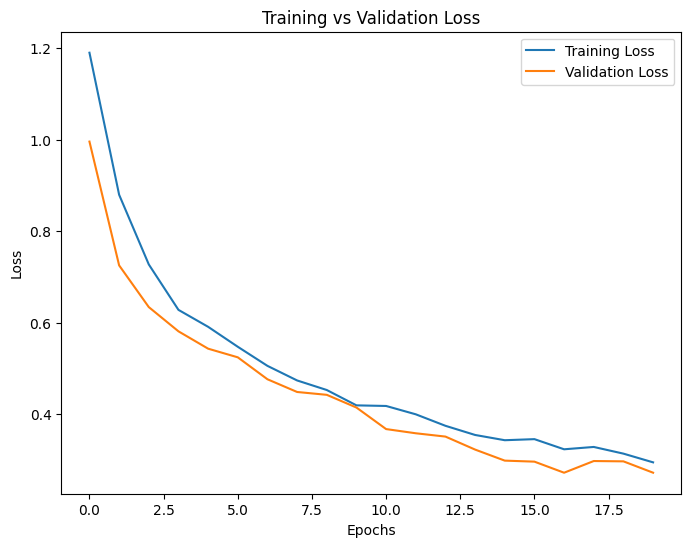

In [33]:
# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Loss Graph
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


# Confusion Matrix


14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 780ms/step


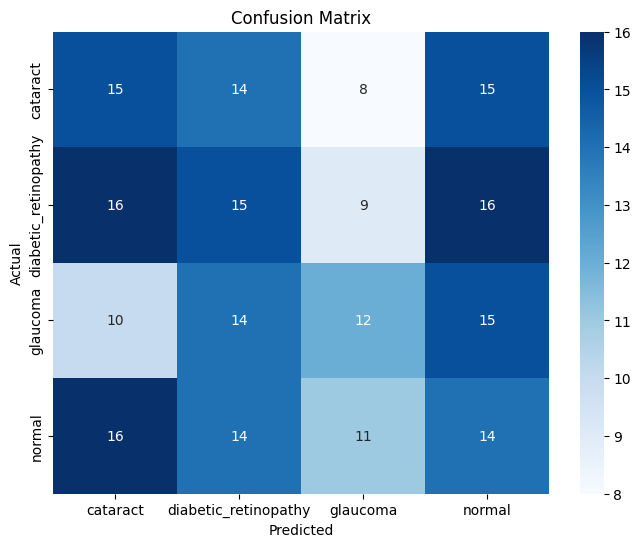

In [34]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



# Classification Report


In [35]:
from sklearn.metrics import classification_report

# Generate report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)

# Print Classification Report
print("Classification Report:\n", report)


Classification Report:
                       precision    recall  f1-score   support

            cataract       0.26      0.29      0.28        52
diabetic_retinopathy       0.26      0.27      0.27        56
            glaucoma       0.30      0.24      0.26        51
              normal       0.23      0.25      0.24        55

            accuracy                           0.26       214
           macro avg       0.26      0.26      0.26       214
        weighted avg       0.26      0.26      0.26       214



# Checking for Overfitting

In [36]:
train_acc = history.history['accuracy'][-1]  # Last epoch training accuracy
val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Compare Accuracy
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Check if Overfitting
if train_acc > val_acc + 0.05:
    print("Model is Overfitting (Training Accuracy is much higher than Validation)")
else:
    print("No major Overfitting detected")


Training Accuracy: 89.12%
Validation Accuracy: 88.06%
Test Accuracy: 86.45%
No major Overfitting detected


# Downloading the model

In [30]:
## /content/hello
from google.colab import files
files.download('/content/xception.h5')  # Replace with your file name


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


<ipython-input-39-a1c5c7f7ac5b>:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


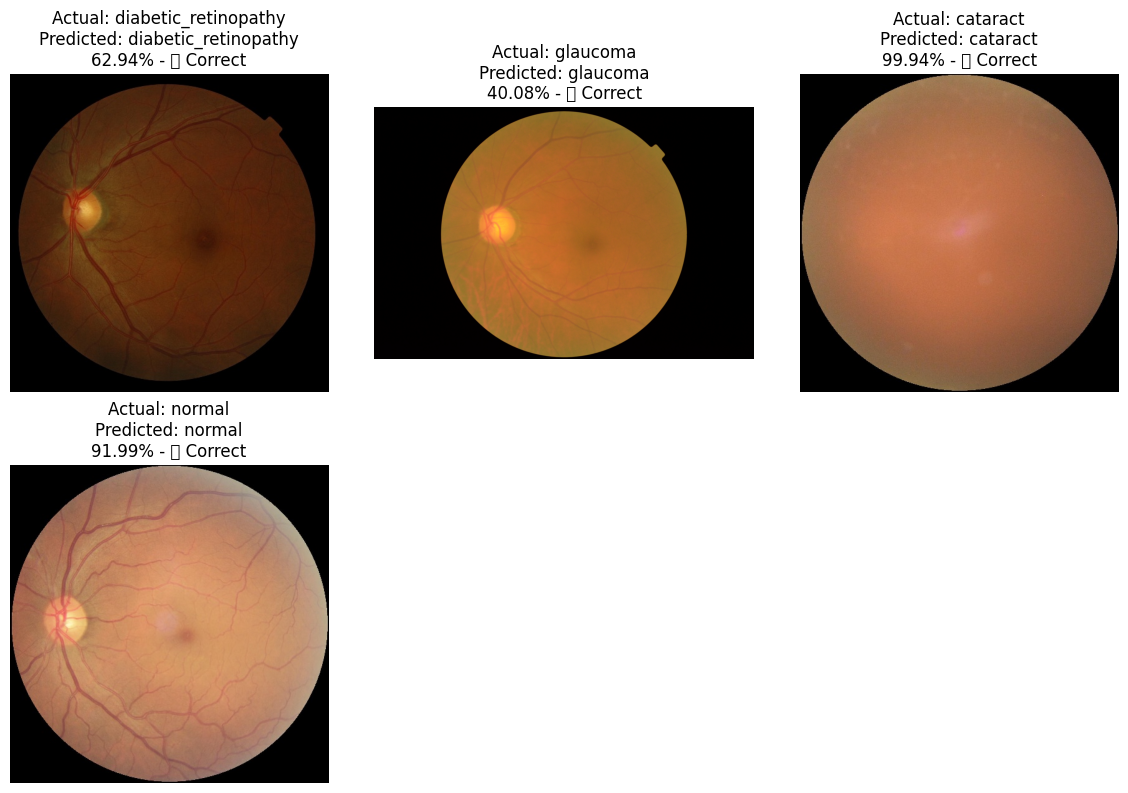


Model Prediction Accuracy on 5 Random Test Images: 80.00%


In [39]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

#  Load 5 random images from the test dataset
test_path = "/content/data/test"
categories = os.listdir(test_path)

random_images = [
    os.path.join(test_path, cat, random.choice(os.listdir(os.path.join(test_path, cat))))
    for cat in categories if os.path.isdir(os.path.join(test_path, cat))
]

random.shuffle(random_images)
random_images = random_images[:5]  # Keep only 5 images

#  Display predictions
plt.figure(figsize=(12, 8))
correct_preds = 0  # Count correct predictions

for i, img_path in enumerate(random_images):
    actual_label = img_path.split("/")[-2]  # Get actual class

    # Load & preprocess the image
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_label = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    result = "Correct" if predicted_label == actual_label else "Wrong"

    if predicted_label == actual_label:
        correct_preds += 1

    # Plot image with prediction
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\n{confidence:.2f}% - {result}")

plt.tight_layout()
plt.show()

#  Print accuracy for the selected images
accuracy = (correct_preds / 5) * 100
print(f"Model Accuracy on 5 Random Test Images: {accuracy:.2f}%")
